The output may vary between different runs in deep learning due to the stochastic nature of training processes, such as random weight initialization, data shuffling, and non-deterministic GPU computations.



In [1]:
import pandas as pd
df=pd.read_excel("Global_ep_Crosssection_with_Poly5_Rational11_SigleDipole_Sum3Dipole_FromFactor.xlsx")

df.head(3)


,Unnamed: 0,Q2 [GeV^2],E0 [GeV],Ep [GeV],theta [deg],eps,sig [nb/sr],dsig number [nb/sr],expt.,normsys [%],...,G_E_fit_poly5,G_M_fit_poly5,delta_G_E_poly5,G_E_fit_dipole,G_M_fit_dipole,delta_G_E_dipole,G_E_fit_sum3,G_M_fit_sum3,delta_G_E_sum3,delta_G_E_rational_11
0,0,0.4253,3.1187,2.8921,12.469,0.973946,887.70,10.0200,27,0.015,...,0.429683,-0.892192,0.003625,0.384646,1.044021,0.004046,0.417089,0.938988,0.003734,0.003595
1,1,0.6198,2.2380,1.9077,21.969,0.918601,109.30,1.1610,27,0.015,...,0.307170,-0.738400,0.003158,0.289622,0.773660,0.003345,0.302019,0.748691,0.003208,0.002973
2,2,0.6213,1.1492,0.8181,47.967,0.682276,17.05,0.1656,27,0.015,...,0.306351,-0.737325,0.002536,0.289032,0.772002,0.002724,0.301273,0.747433,0.002587,0.002344


In [2]:
df.columns

Index(['Unnamed: 0', 'Q2 [GeV^2]', 'E0 [GeV]', 'Ep [GeV]', 'theta [deg]',
       'eps', 'sig [nb/sr]', 'dsig number [nb/sr]', 'expt.', 'normsys [%]',
       'First Author', 'theta_rad', 'tau', 'sigma_Mott', 'sigma_R',
       'delta_sigma_R', 'G_E_fit_rational_11', 'G_M_fit_rational_11',
       'G_E_fit_poly5', 'G_M_fit_poly5', 'delta_G_E_poly5', 'G_E_fit_dipole',
       'G_M_fit_dipole', 'delta_G_E_dipole', 'G_E_fit_sum3', 'G_M_fit_sum3',
       'delta_G_E_sum3', 'delta_G_E_rational_11'],
      dtype='object')

In [3]:
df = df[(df['G_E_fit_rational_11'] > 0) & (df['G_E_fit_rational_11'] < 100)]
df=df[df['Q2 [GeV^2]']<.3]

In [4]:
df['G_E normsys [%]'] = (0.5 * (
    df['G_E_fit_rational_11'] * df['eps'] +
    (df['tau'] * df['G_M_fit_rational_11']**2) / df['G_E_fit_rational_11']
) * (df['normsys [%]']))/df['G_E_fit_rational_11']

Epoch 1/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 165955.4531
Epoch 2/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 132088.1094
Epoch 3/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 95446.9062 
Epoch 4/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 70244.1328
Epoch 5/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 57440.8633
Epoch 6/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 46674.5430
Epoch 7/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 35555.2266
Epoch 8/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 26387.2363
Epoch 9/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18932.2305
Epoch 10/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12819.4355
Epoch 11/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7813.7368
Epoch 12/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5609.8169
Epoch 13/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4734.4028
Epoch 14/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4681.5044 
Epoch 15/600
4/4 ━━━━━━━━━━━━

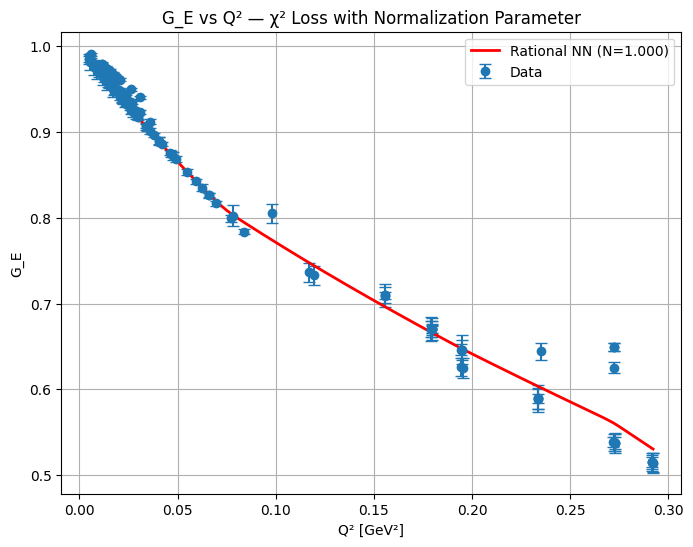

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# === Prepare data ===
Q2 = df['Q2 [GeV^2]'].values.reshape(-1, 1).astype(np.float32)
G_E = df['G_E_fit_rational_11'].values.astype(np.float32)
G_E_err = np.abs(df['delta_G_E_rational_11'].abs().values.astype(np.float32)) + 1e-8
norm_sys = df['G_E normsys [%]'].values.astype(np.float32) / 100  # convert % → fraction
sigma_norm = np.mean(norm_sys)  # global normalization uncertainty

# === Define rational network ===
input_x = Input(shape=(1,), name='input')

num = Dense(120, activation='relu')(input_x)
for _ in range(6):
    num = Dense(120, activation='relu')(num * input_x)
num_out = Dense(1)(num)

den = Dense(120, activation='relu')(input_x)
for _ in range(6):
    den = Dense(120, activation='relu')(den * input_x)
den_out = Dense(1)(den)

epsilon = 1e-6
rational_output = Lambda(lambda x: x[0] / (x[1] + epsilon))([num_out, den_out])

rational_model = Model(inputs=input_x, outputs=rational_output)

# === Add normalization parameter ===
N = tf.Variable(1.0, trainable=True, dtype=tf.float32, name="normalization")

# === Custom chi-square loss with normalization ===
def chi_square_loss(y_true, y_pred):
    residual = (y_true - N * y_pred) / G_E_err
    chi_sq = tf.reduce_mean(tf.square(residual))
    norm_penalty = tf.square((N - 1.0) / sigma_norm)
    return chi_sq + norm_penalty

optimizer = Adam(1e-4)

# === Compile and train ===
rational_model.compile(optimizer=optimizer, loss=chi_square_loss)

history = rational_model.fit(
    Q2, G_E,
    epochs=600,
    batch_size=32,
    verbose=1
)

# === Show learned normalization parameter ===
print(f"\nLearned normalization factor N = {N.numpy():.4f}")

# === Predict and plot ===
Q2_fit = np.linspace(Q2.min(), Q2.max(), 300).reshape(-1, 1).astype(np.float32)
G_E_pred = rational_model.predict(Q2_fit) * N.numpy()

plt.figure(figsize=(8,6))
plt.errorbar(Q2, G_E, yerr=G_E_err, fmt='o', capsize=4, label='Data')
plt.plot(Q2_fit, G_E_pred, 'r-', linewidth=2, label=f'Rational NN (N={N.numpy():.3f})')
plt.xlabel('Q² [GeV²]')
plt.ylabel('G_E')
plt.title('G_E vs Q² — χ² Loss with Normalization Parameter')
plt.grid(True)
plt.legend()
plt.show()


In [6]:
import tensorflow as tf
import numpy as np

# === Compute derivative of G_E(Q²) at Q²=0 using automatic differentiation ===
Q2_zero = tf.constant([[0.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(Q2_zero)
    G_E_0 = N * rational_model(Q2_zero)  # include normalization
dGEdQ2_0 = tape.gradient(G_E_0, Q2_zero)

# === Extract values ===
G_E_0_val = G_E_0.numpy().item()
dGEdQ2_0_val = dGEdQ2_0.numpy().item()

# === Compute radius ===
rE_squared = -6 * dGEdQ2_0_val / G_E_0_val
rE_GeVinv = np.sqrt(abs(rE_squared))  # radius in GeV^-1
rE_fm = rE_GeVinv * 0.197327  # convert to fm (1 GeV^-1 = 0.197327 fm)

print(f"G_E(0) = {G_E_0_val:.6f}")
print(f"dG_E/dQ² at 0 = {dGEdQ2_0_val:.6f}")
print(f"Electric charge radius r_E = {rE_fm:.4f} fm")


G_E(0) = 1.002514
dG_E/dQ² at 0 = -3.081796
Electric charge radius r_E = 0.8475 fm


In [7]:
# Save the rational neural network
rational_model.save('/content/rational_G_E_modellowQ2.keras', include_optimizer=True)


# Save the normalization parameter separately
np.save('/content/normalization_NlowQ2.npy', N.numpy())


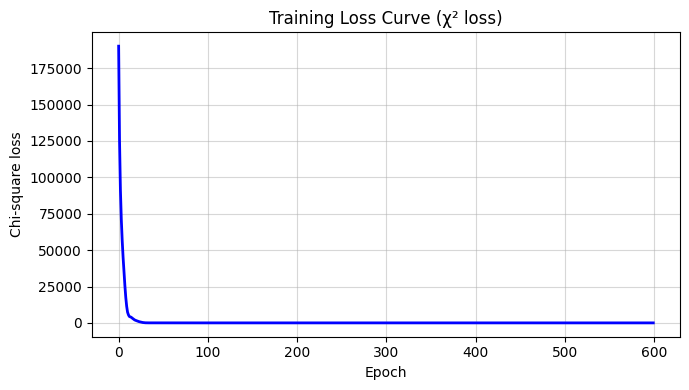


Goodness of Fit (Neural Network):
Total Chi-squared (χ²) = 2269.384
Mean χ² per data point = 19.396


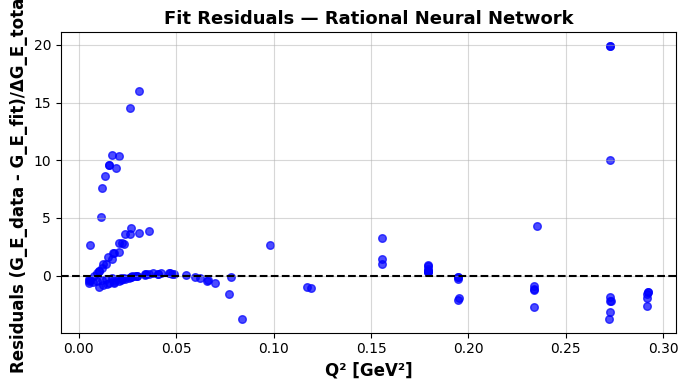

In [8]:
# === Plot training loss curve ===
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], 'b-', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Chi-square loss")
plt.title("Training Loss Curve (χ² loss)")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# === Predict values for training points ===
G_E_pred_train = rational_model.predict(Q2, verbose=0).flatten() * N.numpy()

# === Combine uncertainties ===
G_E_total_err = np.sqrt(G_E_err**2 + (G_E * norm_sys)**2)

# === Compute Chi-squared (meaningful for neural network) ===
chi2 = np.sum(((G_E - G_E_pred_train) / G_E_total_err) ** 2)
chi2_per_point = chi2 / len(G_E)

print(f"\nGoodness of Fit (Neural Network):")
print(f"Total Chi-squared (χ²) = {chi2:.3f}")
print(f"Mean χ² per data point = {chi2_per_point:.3f}")

# === Residuals Plot ===
plt.figure(figsize=(7,4))
residuals = (G_E - G_E_pred_train) / G_E_total_err
plt.scatter(Q2, residuals, s=30, c='blue', alpha=0.7)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Q² [GeV²]", fontsize=12, fontweight='bold')
plt.ylabel("Residuals (G_E_data - G_E_fit)/ΔG_E_total", fontsize=12, fontweight='bold')
plt.title("Fit Residuals — Rational Neural Network", fontsize=13, fontweight='bold')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()
